In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import os
import sys

## Custom Imports

In [2]:
os.chdir("../fashion_ml")

In [5]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader
from experiment import FashionML

## Build Data Loader

In [6]:
dl = EZ_Dataloader("FashionMNIST")

In [7]:
dl.build_train_test_loader()

In [8]:
dl.build_val_loader()

## Build VAE

In [9]:
t = dl.train_loader.dataset

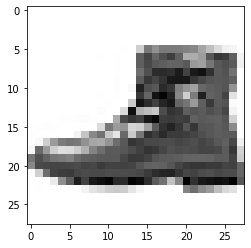

In [10]:
import matplotlib.pyplot as plt
a = t[12342][0]
plt.imshow(torch.squeeze(a), cmap = "Greys")

In [11]:
fvae = FashionVAE(h_dims = [32,64,128])

In [12]:
fvae

FashionVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder_latent_space): Linear(in_features=2, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Sequent

In [13]:
adam = torch.optim.Adam

In [14]:
fml = FashionML(fvae, dl, adam)

In [15]:
fml.epochs = 100

In [ ]:
fml.fit()

Validation Loss: 3.420644521713257
Validation Loss: 2.982944965362549
Validation Loss: 2.860074520111084
Validation Loss: 2.8028180599212646
Validation Loss: 2.7614126205444336
Validation Loss: 2.7502102851867676
Validation Loss: 2.7453620433807373
Validation Loss: 2.7009029388427734
Validation Loss: 2.6860644817352295
Validation Loss: 2.6624391078948975
Validation Loss: 2.6554625034332275
Validation Loss: 2.6535701751708984
Validation Loss: 2.6347761154174805
Validation Loss: 2.6349878311157227
Validation Loss: 2.6446847915649414
Validation Loss: 2.639855146408081
Validation Loss: 2.608280658721924
Validation Loss: 2.5985331535339355
Validation Loss: 2.610464572906494
Validation Loss: 2.6016502380371094
Validation Loss: 2.6179306507110596


In [ ]:
latent, t = fvae.sample(1, include_locations= True)

print(latent)

In [ ]:
plt.imshow(torch.squeeze(t.detach().cpu()), cmap = "Greys")

In [ ]:
torch.save(fml.model.state_dict(), "../models/")

In [ ]:
img = []
for i in range(20):
    i1 = (i-10)/2
    row = []
    for j in range(20):
        i2 = (j-10)/2
        
        row.append(torch.squeeze(fml.model.sample_latent((i1,i2))))
    
    img.append(torch.cat(row, axis = 1))

img = torch.cat(img, axis = 0)

In [ ]:
img.shape

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(img)
plt.axes("off")

In [ ]:
a = torch.tensor([[1,2,3],
                 [1,2,3]])
b = torch.tensor([[1,2,3],
                 [1,2,3]])

c = torch.cat([a,b], axis = 1)
c.shape